# Dumb Contracts

The purpose of this notebook is to train a model capable of determining whether a pair launched on uniswap is a scam or a legit token.
This will be done through a hybrid model, mainly focusing on NLP to classify the Source Code for the Solidity Smart Contract.

In [1]:
import pandas as pd
import tensorflow as tf

## Understanding The Data

The data i.e the smart contract source codes, have been sourced primarily from the etherscan API and trading pool details(for purpose of identifying whether a token is a scam or not) have been sourced from the Uniswap GraphQL API. These have all been dumped into a text file and will need preprocessing.

In [2]:
data_path = 'data/dumb_contracts.txt'

In [3]:
def separate_code_and_comments(contract):
    """
    Takes in a Solidity contract as a string and separates the code and comments into two different strings.
    """
    code = ""
    comments = ""

    # Split the contract into lines
    lines = contract.split("\n")

    # Iterate through each line and separate the code and comments
    for line in lines:
        line = line.strip()

        # If the line is a comment, add it to the comments string
        if line.startswith("//"):
            comments += line + "\n"

        # If the line is a multi-line comment, add it to the comments string
        elif line.startswith("/*"):
            comments += line + "\n"
            while not "*/" in line:
                line = lines.pop(0).strip()
                comments += line + "\n"

        # Otherwise, add it to the code string
        else:
            code += line + "\n"

    return code.strip(), comments.strip()

In [4]:
def separate_comments(contract_text):
    lines = contract_text.split("\n")
    block_comments = []
    code = []
    in_block_comment = False
    for line in lines:
        if line.strip().startswith("/*"):
            in_block_comment = True
            block_comments.append(line)
        elif in_block_comment:
            block_comments.append(line)
            if "*/" in line.strip():
                in_block_comment = False
        elif "//" in line:
            # Check if the comment is at the start of the line or after some code
            idx = line.find("//")
            if idx > 0:
                code.append(line[:idx])
            block_comments.append(line[idx:])
        else:
            code.append(line)
    return ('\n'.join(code), '\n'.join(block_comments))


In [5]:
import json
from pprint import pprint
def preprocess_text(filepath):
  """
  Returns a list of dicts
  """
  divider = "\n\n!!!!DIVIDER!!!!\n\n"
  with open(filepath, "r", encoding="utf8") as f:
    file_contents = f.read()

  main_sections = file_contents.split(divider)

  parsed_data = []
  for section in main_sections[1:]:
    parsed_section = {}
    details, contracts = section.split('\n\n!!!!TOKEN_CONTRACT!!!!\n\n')
    token_contract, pair_contract = contracts.split("\n\n!!!!PAIR_CONTRACT!!!!\n\n")
    for subsection in details.split("\n\n"):
      key, value = subsection.split(":\n")
      parsed_section[key.lower()] = value
    parsed_section['contract_type'] = 0
    if token_contract.startswith('{'):
      if token_contract.startswith('{{'):
        token_contract_dict = json.loads(token_contract.replace('{{', '{').replace('}}', '}'))['sources']
        parsed_section['contract_type'] = 1
      else:
        token_contract_dict = json.loads(token_contract)
        parsed_section['contract_type'] = 2
      token_contract_values = []
      for value in token_contract_dict.values():
        token_contract_values.append(value['content'])
      token_contract = '\n'.join(token_contract_values)
    try:
      token_contract_code, token_contract_comments = separate_comments(token_contract)
    except Exception as e:
      print(token_contract)
      print(e)
      quit()
    parsed_section['token_contract_code'] = token_contract_code
    parsed_section['token_contract_comments'] = token_contract_comments
    parsed_section['pair_contract'] = pair_contract
    parsed_data.append(parsed_section)

  return parsed_data    


In [6]:
from os.path import exists

preprocessed_json_path = "./data/final_data.json"
if exists(preprocessed_json_path):
  with open(preprocessed_json_path, 'r') as json_file:
    preprocessed_data = json.load(json_file)
else:
  preprocessed_data = preprocess_text(data_path)
  with open(preprocessed_json_path, 'w') as json_file:
    json.dump(preprocessed_data, json_file)

In [7]:
preprocessed_data[99]

{'token_address': '0x8e919103cd40a4dcd14268b480bd48811ff26222',
 'pair_address': '0x9d45516e29c928191322ddb1638768b11adbda99',
 'weth_trade': '3.0219253756588076',
 'weth_left': '1.2031729271394982',
 'creation_time': '1680160139',
 'launch_time': 1680211835,
 'contract_type': 0,
 'token_contract_code': '\n\npragma solidity 0.8.17;\n\ninterface IERC20 {\n    function totalSupply() external view returns (uint256);\n    function balanceOf(address account) external view returns (uint256);\n    function transfer(address recipient, uint256 amount) external returns (bool);\n    function allowance(address owner, address spender) external view returns (uint256);\n    function approve(address spender, uint256 amount) external returns (bool);\n    function transferFrom(\n        address sender,\n        address recipient,\n        uint256 amount\n    ) external returns (bool);\n   \n    event Transfer(address indexed from, address indexed to, uint256 value);\n    event Approval(address indexed o

In [8]:
df = pd.DataFrame(preprocessed_data)
to_numerical = ["weth_trade", "weth_left", "creation_time"]
df[to_numerical] = df[to_numerical].apply(pd.to_numeric)

In [9]:
df.head()

,token_address,pair_address,weth_trade,weth_left,creation_time,launch_time,contract_type,token_contract_code,token_contract_comments,pair_contract,opening_hour_prices,tokens_added,eth_added,token_decimals,method
0,0xad1062dfdca3af9df432269cee59c3da7bdad80c,0x3e336613331f735570e5d77b8e98508a0cb94993,10.682207,1.533046e+00,1680192059,1680192059,0,\npragma solidity 0.8.19;\n\nabstract contract...,/**\n*/\n// SPDX-License-Identifier: MIT\n/**\...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1680192000, 'price': 3.42284343...",4.250000e+08,1.5,9,openTrading
1,0xc88ce7cb0e6c5f3bbdb593a4914c2d2163011c0c,0x3b0d398291420f665d06f53caff2336dc8e4ff38,3.310797,1.173680e+00,1680192143,1680192143,1,pragma solidity 0.8.19;\n\nabstract contract C...,// SPDX-License-Identifier: MIT\n/**\nTweelon\...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1680192000, 'price': 1.80943510...",7.840000e+05,1.0,8,openTrading
2,0xeb53f41dca9cb7cc470fd204c9b997d871bdba00,0xd99cc491e430be5908845bf4bdc43bb524842b10,0.320603,1.000000e-18,1680192995,1680195047,0,\n\n\n\npragma solidity ^0.8.9;\n\nabstract co...,//Sorry for the problem that made last contrac...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1680192000, 'price': 1.29022389...",5.120194e+09,1.0,9,addLiquidityETH
3,0xc363f4745b39d204262164d8afab9984ea68b6b3,0xda823ae19da89f88009f81b20849e91c79b8d2cc,7.920321,1.763287e+00,1680193223,1680194135,0,\n\npragma solidity 0.8.17;\n\n\nlibrary SafeM...,// telegram : https://t.me/AtlasERC\n// SPDX-L...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1680192000, 'price': 5.63555551...",9.700000e+07,0.9,9,addLiquidityETH
4,0xb69584b821b07d0f95c0dee5b7905ff428803b4a,0xeb3ba163fb903fdc150a41b2fd850a67a6775da8,1.118763,1.000000e-18,1680193307,1680193499,0,...,// SPDX-License-Identifier: MIT ...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1680192000, 'price': 1.07308488...",5.000000e+11,3.0,18,addLiquidityETH


In [54]:
df[(df['eth_added']>0) & (df['eth_added']>100)].sort_values(by=['eth_added'], ascending=False)

,token_address,pair_address,weth_trade,weth_left,creation_time,launch_time,contract_type,token_contract_code,token_contract_comments,pair_contract,opening_hour_prices,tokens_added,eth_added,token_decimals,method
850,0xcac30368ae9e0435b2bf5901463e5909e9f18fe7,0x648f616f2a1007ee5a1be56b31c2683a1a94c2ec,12.151083,9.838140e-01,1679868635,1679868635,0,\n\npragma solidity ^0.8.18;\n\ninterface IERC...,//SPDX-License-Identifier: MIT\n/*\nDeployed b...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1679868000, 'price': 3.41771041...",1.000000e+09,9.300000e+01,9,openTrading
709,0x2c5bc2ba3614fd27fcc7022ea71d9172e2632c16,0xf126ac81688aa0fc16aa41361a3891b6cd78736f,7860.123085,1.724887e-02,1679924015,1679929583,1,"\npragma solidity ^0.8.0;\n\nimport ""../utils/...",// SPDX-License-Identifier: MIT\n// OpenZeppel...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1679929200, 'price': 2.22720243...",5.000000e+13,8.600000e+01,18,addLiquidityETH
2289,0xb197a6fdd8ab825332edeba1ab5c4d1bf97fb9a8,0x5fd4057228529865ae3c09d79fbed31c32a9daed,51.231055,5.621981e+01,1679248727,1679869211,1,\npragma solidity ^0.8.7;\n\nabstract contract...,/**\n\n ______ __ __ __ ______ ...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1679868000, 'price': 8.45185314...",5.000000e+07,8.000000e+01,18,addLiquidityETH
4376,0x3768891d1d94dfa56c33e9de0029e41d0169eadf,0x90be1aa9588c051f11e8cf67cadbda665653dd0c,1165.966691,6.608268e+01,1678234235,1678234235,0,\n\npragma solidity 0.8.7;\n\ninterface IERC20...,// SPDX-License-Identifier: Unlicensed\n// Gas...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1678233600, 'price': 1.31070748...",1.200000e+09,6.000000e+01,9,addLiquidityETH
3174,0x521b84584cc381dd32233884459bc29841c9be77,0x5a33577f170bfd7c52487ce1bef55d4bd271586d,99.856970,9.149170e+01,1678883783,1678883903,0,\n\n\npragma solidity ^0.8.0;\n\ninterface IER...,// File: @openzeppelin/contracts/token/ERC20/I...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1678881600, 'price': 1.60718976...",3.500000e+07,5.000000e+01,18,addLiquidityETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,0xba5bd3d5644f570738eecd5ad9639e6f712dae87,0x545636ac2ac23f67bab97c06e7164fcb9962ad8e,131.165516,1.125643e-04,1678979951,1678979951,0,\n\n\n\npragma solidity ^0.8.0;\n\nabstract co...,// SPDX-License-Identifier: MIT\n// File: @ope...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1678978800, 'price': 1.96162235...",1.705674e+05,1.000000e-05,18,addLiquidityETH
954,0x262fd407aa98bf39231b9fed8e71b8e47048bfbd,0xf68401a9c928b43ad4f1bbcda413b79035913147,10.726413,3.304033e-01,1679801759,1679801855,0,\n\npragma solidity =0.8.10 >=0.8.10 >=0.8.0 <...,/**\n\nOne Cent Inu is a token on ethereum net...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1679799600, 'price': 5.29532756...",2.000000e+08,5.700000e-06,18,addLiquidityETH
1553,0xfb4a83fb12c0bc67243e632425ca737c3cb4318b,0xa9cac16fe9f7ceabfdd0d99a8168a27d23037d52,5.001080,1.000000e-18,1679513123,1679513123,0,pragma solidity 0.8.18;\n\ninterface IERC20 {\...,// SPDX-License-Identifier: Unlicensed\n/**\n ...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1679511600, 'price': 1.39851546...",9.000000e+02,1.000000e-06,18,openTrading
2233,0xfaeb5b61d7b232f33e33d0d4f61d9ed2ac9c8570,0xf310d9cf98a1d7687f459902b0b87647f60d8c9b,2.229913,9.912500e-03,1679258891,1679259083,0,\n\npragma solidity ^0.8.8;\n\ninterface IBEP2...,// telegram : https://t.me/ChadGPT_eth\n// SPD...,// File: contracts/interfaces/IUniswapV2Pair.s...,"[{'timestamp': 1679256000, 'price': 1.72420830...",9.000000e+01,9.000000e-10,9,addLiquidityETH


<AxesSubplot:xlabel='eth_added', ylabel='Count'>

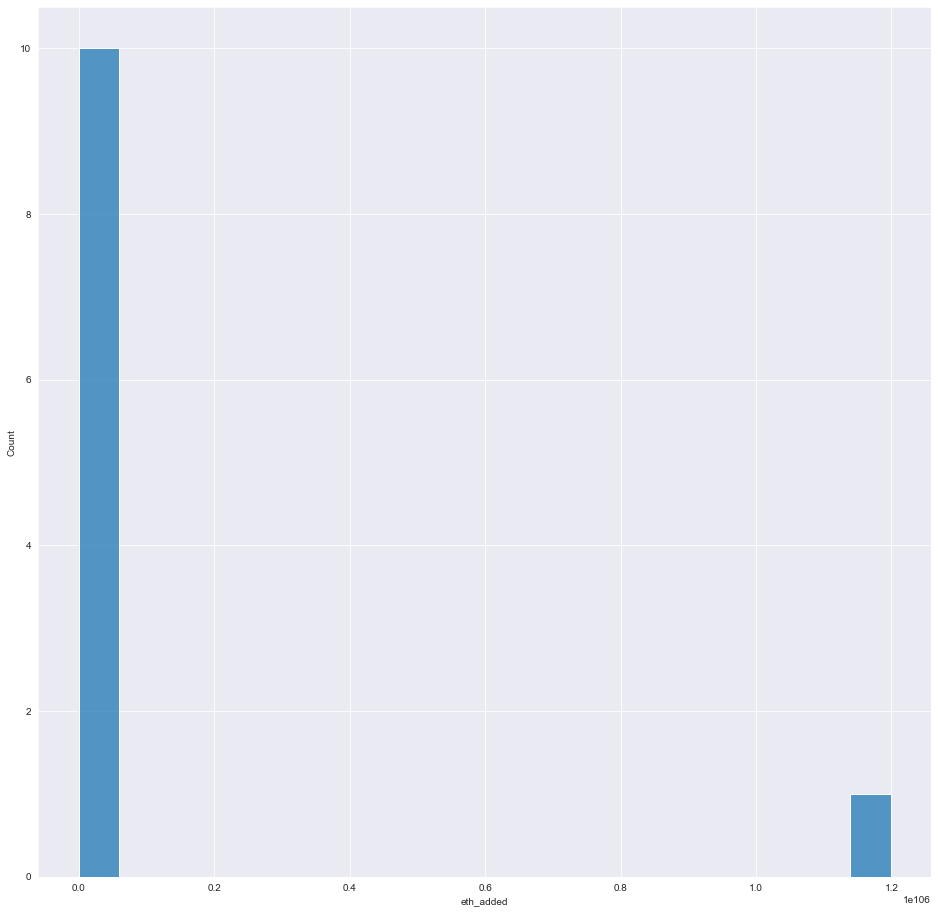

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(16, 16))
sns.histplot(df[df['eth_added']>100]['eth_added'], bins=20)

## Identifying targets

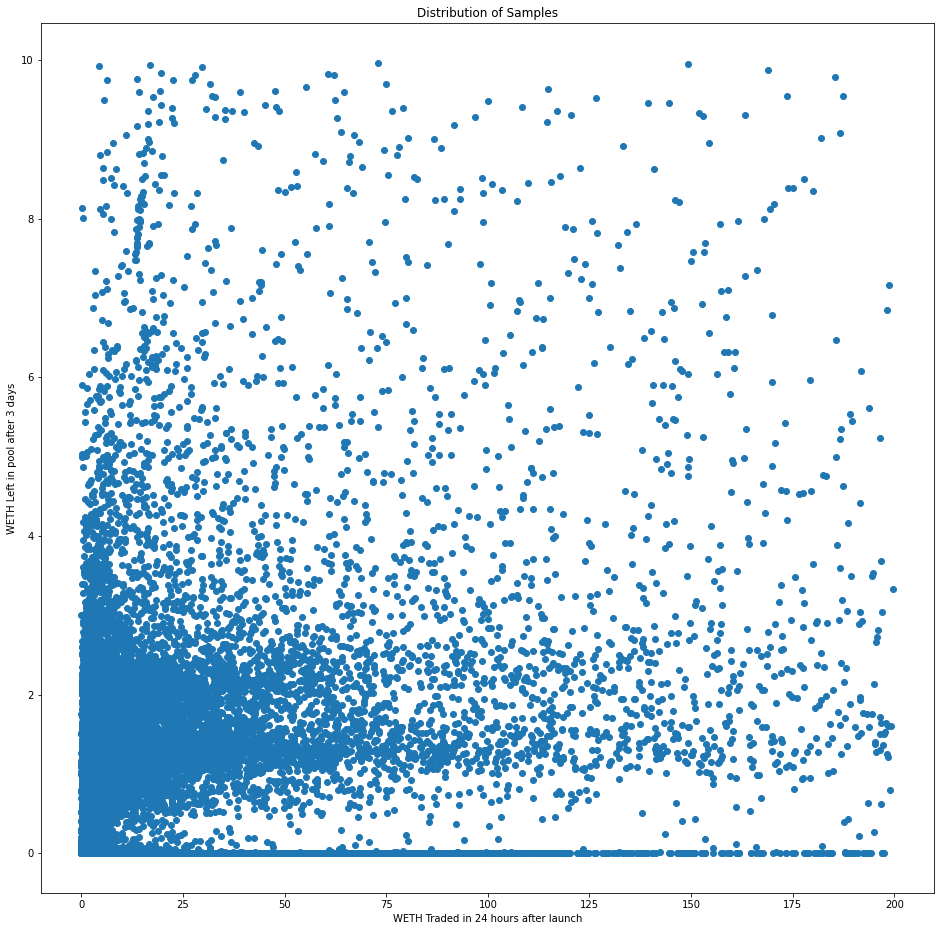

In [10]:
small_df = df[(df['weth_trade'] < 200) & (df['weth_left'] < 10)]
# small_df = df

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
plt.scatter(list(small_df.weth_trade), list(small_df.weth_left))
plt.xlabel('WETH Traded in 24 hours after launch')
plt.ylabel('WETH Left in pool after 3 days')
plt.title('Distribution of Samples')
plt.show()

In [11]:
df[(df['weth_left']>6)&(df['weth_trade']< 20)]

,token_address,pair_address,weth_trade,weth_left,creation_time,launch_time,contract_type,token_contract_code,token_contract_comments,pair_contract
321,0xd06b1daefc2efd41119a0a0b397745cd276eeadb,0x9d683923d9ac8db3dc10a564c2ad0d5c46a73602,8.597184,8.625916,1680094007,1680091200,0,\n\n\npragma solidity ^0.8.17;\n\n\n\nabs...,/** \n\n\n\n\n ┏━━┓┏━━━┳━━━┳┓┏━┳━━━┓\...,// File: contracts/interfaces/IUniswapV2Pair.s...
334,0x6a31a093519d70739da23611aadd99cbba49247f,0xc1b55d64d9aa8ef3ec5d4524bcf4142a504e0929,19.637134,9.427578,1680102059,1680102000,0,\n\n\npragma solidity =0.8.10 >=0.8.10 >=0.8.0...,/*\nZKCONTINUUM\nExplore a rapid and secure EV...,// File: contracts/interfaces/IUniswapV2Pair.s...
723,0x6b41e2a3c6c11756383574618d7cf13b9247a228,0xb2dbccdfcc093f4d77ae421b53faae247ff6d2ef,5.692084,6.379881,1679942291,1679940000,0,pragma solidity ^0.8.9;\n\nabstract contract C...,// SPDX-License-Identifier: Unlicensed\n//Orig...,// File: contracts/interfaces/IUniswapV2Pair.s...
914,0x4b49399f5b03ea56097f7bf27b8b8a91e85a3160,0x41f9c83dbdbca38d7dfedba567cc7063c97d5f3d,10.785823,6.960310,1679858999,1679857200,0,pragma solidity 0.8.18;\n\nabstract contract C...,/*\n*/\n// SPDX-License-Identifier: Unlicensed...,// File: contracts/interfaces/IUniswapV2Pair.s...
1070,0x743bb831341a4a3eafe224f5c70e82c621b8fbd3,0x28c6b19f0a445381f7c5e214f95a464176882db7,17.575499,7.902521,1679770151,1679770800,0,\npragma solidity =0.8.10 >=0.8.10 >=0.8.0 <0....,/**\n *Submitted for verification at Etherscan...,// File: contracts/interfaces/IUniswapV2Pair.s...
...,...,...,...,...,...,...,...,...,...,...
39819,0x7101a9392eac53b01e7c07ca3baca945a56ee105,0x81b786ed4b2f1118e0fa0343ad4760e15448e3e8,8.686153,13.869028,1664307947,1664337600,0,pragma solidity ^0.8.15;\n\n\nabstract contrac...,// SPDX-License-Identifier: MIT\n/*\n\n /$$ ...,// File: contracts/interfaces/IUniswapV2Pair.s...
39820,0x7102dc82ef61bfb0410b1b1bf8ea74575bf0a105,0x49c838c60170c36e90cfa6021a57f2268dda3254,7.387425,13.685519,1664307995,1664337600,0,pragma solidity ^0.8.15;\n\n\nabstract contrac...,// SPDX-License-Identifier: MIT\n/*\n\n /$$ ...,// File: contracts/interfaces/IUniswapV2Pair.s...
39821,0x7103ebdbf1f89be2d53eff9b3cf996c9e775c105,0xcecf54edc42c5c9f6ee10cb1efcc23e49f7d5a5d,9.537171,14.204068,1664308043,1664337600,0,pragma solidity ^0.8.15;\n\n\nabstract contrac...,// SPDX-License-Identifier: MIT\n/*\n\n /$$ ...,// File: contracts/interfaces/IUniswapV2Pair.s...
39822,0x7104d1f179cc9cc7fb5c79be6da846e3fbc4c105,0x7d0d7c088233cbc08ee2400b96d10bf24c40e93a,5.662534,14.071459,1664308151,1664337600,0,pragma solidity ^0.8.15;\n\n\nabstract contrac...,// SPDX-License-Identifier: MIT\n/*\n\n /$$ ...,// File: contracts/interfaces/IUniswapV2Pair.s...


In [12]:
df['time_difference'] = df['launch_time'] - df['creation_time']

In [13]:
##Resetting negative time differences to zero. The negative numbers arise when trading starts in the same hour a pair was launched
import numpy as np
df['time_difference'] = np.where(df['time_difference']< 0, 0, df['time_difference'])

In [14]:
df[(df['weth_trade'] > 47) & (df['weth_left'] > 0.01)]['time_difference'].mean()

24280.56893776824

In [15]:
df[(df['weth_trade'] < 47) & (df['weth_left'] < 0.01) ]['time_difference'].mean()

3874.131639928699

In [16]:
df[(df['weth_trade'] > 47) & (df['weth_left'] > 0.01)].sort_values(by=['weth_trade'])

,token_address,pair_address,weth_trade,weth_left,creation_time,launch_time,contract_type,token_contract_code,token_contract_comments,pair_contract,time_difference
39174,0x8b614c226068efc76e9d62dddca67dd2faf37a1a,0x3711362e16942b9e703d693b4df58d9ec47d0509,47.030289,2.245362,1664553719,1664560800,0,\npragma solidity 0.8.9;\n\nabstract contract ...,// SPDX-License-Identifier: MIT\n// silence st...,// File: contracts/interfaces/IUniswapV2Pair.s...,7081
15199,0xab3d91ddf897276ea83f54930cede877c2f754d6,0x71f400446a7d6107ffb5850c05532ef904e80998,47.060635,1.206510,1673176115,1673182800,0,\npragma solidity ^0.8.7;\n \nabstract contrac...,// SPDX-License-Identifier: unlicense,// File: contracts/interfaces/IUniswapV2Pair.s...,6685
15902,0xd7e740a65cd4c566d69c20ab6268f74704c03b70,0x16acc77f1344b05c34e3968e77494ffb3007fd12,47.070828,1.240446,1672937123,1672934400,0,\n\npragma solidity =0.8.10 >=0.8.10 >=0.8.0 <...,// TG: t.me/CheeboInu\n// Twitter: https://twi...,// File: contracts/interfaces/IUniswapV2Pair.s...,0
19079,0x6eb59138dd11b964fc548e2548279923310b0a96,0xff3a89420b0fffdc1c611631ff534ec8a74ef071,47.083417,2.083856,1671682859,1671721200,0,pragma solidity ^0.8.9;\n \nabstract contract ...,/**\n \n Merry Wishmas \n\n*/\n// SPDX-License...,// File: contracts/interfaces/IUniswapV2Pair.s...,38341
7074,0x4fd5e9784a92a1bd56ea2c3ced027e862c537fd9,0xaaf57c36fdfd614aa9a0cb04b2e182e29d00f3cd,47.105096,2.181926,1676778911,1676847600,0,pragma solidity ^0.8.9;\n\nabstract contract C...,/**\n👨IntelliChef (@IntelliChefBot)\nYour New ...,// File: contracts/interfaces/IUniswapV2Pair.s...,68689
...,...,...,...,...,...,...,...,...,...,...,...
9794,0xdc63269ea166b70d4780b3a11f5c825c2b761b01,0x428b03ccd51ee4fcff7df6c7deae4139a4b347ed,16226.572369,0.148169,1675506203,1675504800,0,\n\n\n\npragma solidity ^0.8.0;\n\ninterface I...,// SPDX-License-Identifier: MIT\n// File: @ope...,// File: contracts/interfaces/IUniswapV2Pair.s...,0
33758,0x6ef6610d24593805144d73b13d4405e00a4e4ac7,0xd1c9cbe7f1975b599b9189ce132a433c4a3c8986,18825.297526,97.692281,1666268999,1666267200,0,\n\npragma solidity 0.8.15;\n\nabstract contra...,// SPDX-License-Identifier: MIT\n/**\n\n\n\n*/...,// File: contracts/interfaces/IUniswapV2Pair.s...,0
26103,0x49642110b712c1fd7261bc074105e9e44676c68f,0x82d6b30bff73c6363d024cbc2f44d1cbbee5972e,21379.109138,3.289079,1668589571,1668589200,0,\n\n\n\npragma solidity ^0.8.0;\n\ninterface I...,// SPDX-License-Identifier: MIT\n// File: @ope...,// File: contracts/interfaces/IUniswapV2Pair.s...,0
36804,0x06450dee7fd2fb8e39061434babcfc05599a6fb8,0xc0d776e2223c9a2ad13433dab7ec08cb9c5e76ae,45226.724286,4.653500,1665331451,1665334800,1,"pragma solidity ^0.8.10;\n\nimport ""./Math.sol...",// SPDX-License-Identifier: MIT\n// INTERNAL T...,// File: contracts/interfaces/IUniswapV2Pair.s...,3349


In [17]:
df['target'] = np.where((df['weth_trade'] > 47) & (df['weth_left'] > 0.01), 1, 0)

In [18]:
df['target'].value_counts()

0    36296
1     3728
Name: target, dtype: int64

In [19]:
df['token_contract_code_len'] = df['token_contract_code'].apply(lambda x: len(x.split()))
df['token_contract_comments_len'] = df['token_contract_comments'].apply(lambda x: len(x.split()))

In [20]:
df.sort_values(by=['token_contract_comments_len'], ascending=True)[['token_address', 'token_contract_comments_len', 'contract_type']]

,token_address,token_contract_comments_len,contract_type
22927,0xb2b7e621e903e6d8b4979541aafa7d486a2cd3c5,0,0
28324,0x8b4a4e80e40aa7c3b18a804664c4c1acdfdfd12d,0,0
35194,0x8ab106ab92bca4f64cbf4302a82d6d9df130237e,0,0
21690,0xfe46a3930d5bf7926f1f469ea8437c90866bddad,0,0
39139,0xdfeacea46ca4165f63501dd64dcafa4a5becf587,0,0
...,...,...,...
13585,0xba608ab350f1b7602a7a234c70ea5b4a66260b50,11227,1
13543,0x3c64beb87c58ebc7f666727b741fefb27e9a7d56,11227,1
6485,0xfb439f14c54fcc42d7ccfea1e87625cad0297305,12109,0
6497,0xedd7bdc706e7e822495cabdda6c17289d11c8f03,13181,0


In [21]:
df[(df['contract_type'] == 0) & (df['target']==0)]['token_contract_comments_len'].mean(), df[(df['contract_type'] == 0) & (df['target']==1)]['token_contract_comments_len'].mean()

(736.4022523474533, 1082.5223835450695)

In [22]:
df[(df['contract_type'] == 1) & (df['target']==0)]['token_contract_comments_len'].mean(), df[(df['contract_type'] == 1) & (df['target']==1)]['token_contract_comments_len'].mean()

(948.1309728429013, 1150.2871794871794)

In [23]:
df[(df['contract_type'] == 2) & (df['target']==0)]['token_contract_comments_len'].mean(), df[(df['contract_type'] == 2) & (df['target']==1)]['token_contract_comments_len'].mean()

(1440.9172932330828, 1566.1875)

In [24]:
df[(df['contract_type'] == 0) & (df['target']==0)]['token_contract_code_len'].mean(), df[(df['contract_type'] == 0) & (df['target']==1)]['token_contract_code_len'].mean()

(1582.4958787476223, 1716.5335753176043)

In [25]:
df[(df['contract_type'] == 1) & (df['target']==0)]['token_contract_code_len'].mean(), df[(df['contract_type'] == 1) & (df['target']==1)]['token_contract_code_len'].mean()

(1452.2825713303541, 1653.7692307692307)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='token_contract_comments_len', ylabel='Count'>

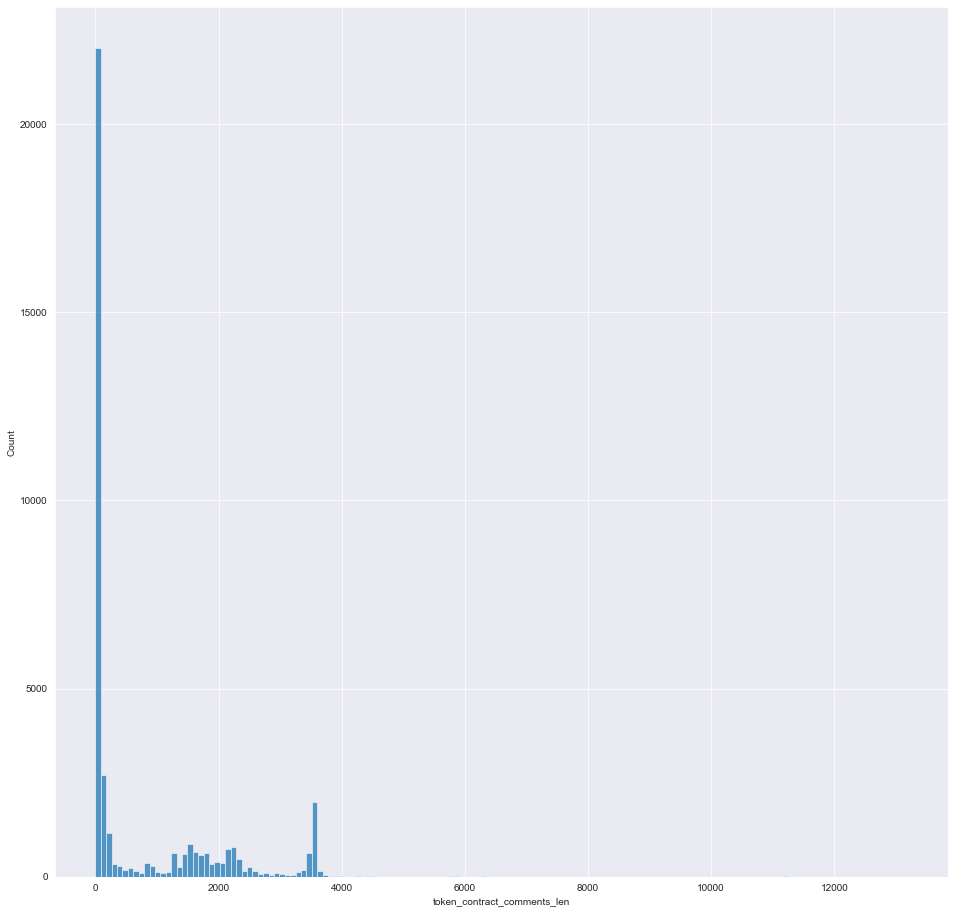

In [27]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 16))
sns.histplot(df['token_contract_comments_len'])

In [28]:
df.sort_values(by=['token_contract_code_len'])

,token_address,pair_address,weth_trade,weth_left,creation_time,launch_time,contract_type,token_contract_code,token_contract_comments,pair_contract,time_difference,target,token_contract_code_len,token_contract_comments_len
20298,0xd458983d38b05382866dde11ca2de7726a1c1f4d,0x69aa46064624e70439ff1000eebc845ebc482b79,24.796877,1.000000e-18,1671138959,1671138000,0,,/** https://linktr.ee/isoprotocol */\n\n// SPD...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,0,2290
21659,0xeada539b4204e27da7d17f4748e8f7c835991a42,0x3ecac274541d9e7945dea168e63b578b8670de7d,11.048149,1.211460e+00,1670593283,1670590800,0,,/* Fable of War */\n\n/* PEACE */\n\n/* http:/...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,0,1597
33635,0x6c550ebd3f8708b784a006efbd5b3814880eb10a,0x067597b1fd401c12647a282a7d32804a0c302bf5,0.404038,3.656000e-15,1666293887,1666292400,0,,/*⫘⫘⫘⫘⫘⫘⫘⫘⫘⫘ 🅳🅸🅴🅸🅽🆄 ⫘⫘⫘⫘⫘⫘⫘⫘⫘⫘*/\n// Telegram ...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,0,1587
9524,0x4859c9b474e56e7c76b37323820154af0abd45d3,0x17ca783262e89686a4320500046bb56131a56e49,197.059626,1.972896e-03,1675615367,1675612800,0,,//SPDX-License-Identifier: MIT\n/* Aibot.onl :...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,0,766
20135,0xfa6f003755680350c4ff9dde15aa8ca71685e2cc,0xf58fdf47f74f44799bb5c79483198d568db896db,0.177955,4.710000e-15,1671225407,1671224400,1,,// SPDX-License-Identifier: UNLICENSED \n/****...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,0,1286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6180,0x34cc1978fef755d03c058cf75d420a61dfeb4b57,0x8bd03c13f16c9b4f943935e8d94e21aa1f220b69,44.684265,6.004996e+00,1677346307,1677344400,1,"pragma solidity ^0.8.9;\nimport ""@openzeppelin...",// SPDX-License-Identifier: UNLICENSED\n// Imp...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,7748,2921
30403,0x71771e820a9414b5f415b7f14d51701502c1f753,0x0b44e1001e40d3a9e25bcd5537128d77c569eaa3,32.319075,4.279392e+00,1666967147,1666969200,1,"\r\n\r\nimport ""hardhat/console.sol"";\r\n\r\n\...",//SPDX-License-Identifier: MIT\r\n// Solidity ...,// File: contracts/interfaces/IUniswapV2Pair.s...,2053,0,8156,131
283,0x5b92c991deb8eef1a95d8c650d99e83518e5171e,0x9f2a8ba45287db84abab366cb02cf314e7b7b38d,4.409092,1.000000e-18,1680107303,1680105600,0,\n\n\npragma solidity ^0.8.10;\n\nabstract con...,/*\n\nhttps://twitter.com/WatcherGuru/status/1...,// File: contracts/interfaces/IUniswapV2Pair.s...,0,0,8797,2267
33559,0x94b4d6c082fcb3d818aab09747ac59cdcd4c0ff4,0x1058a29515b5f661ac2f292faebe41cc163cf401,3.253473,1.000000e-18,1666303175,1666303200,0,\npragma solidity ^0.8.0;\n\nabstract contract...,// SPDX-License-Identifier: MIT\n/**\n * @dev ...,// File: contracts/interfaces/IUniswapV2Pair.s...,25,0,8817,2264


## Trying different models

In [29]:
# Getting small sample of data

small_df = df.sample(n=5000)

In [30]:
small_df['target'].value_counts()

0    4528
1     472
Name: target, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(small_df, test_size=0.3)
val_df, test_df = train_test_split(test_df, test_size=0.5)

len(train_df), len(val_df), len(test_df)

(3500, 750, 750)

In [32]:
print(train_df.target.value_counts())
print(val_df.target.value_counts())
print(test_df.target.value_counts())

0    3153
1     347
Name: target, dtype: int64
0    682
1     68
Name: target, dtype: int64
0    693
1     57
Name: target, dtype: int64


In [33]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")

# Tokenize the text data
max_length = 64
train_encodings = tokenizer(list(train_df['token_contract_code'].values), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(list(val_df['token_contract_code'].values), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_df['token_contract_code'].values), truncation=True, padding=True, max_length=max_length)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['target'].values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_df['target'].values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['target'].values
))

# Load the pre-trained model
model = TFAutoModelForSequenceClassification.from_pretrained("huggingface/CodeBERTa-small-v1", num_labels=2)

# Define the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
class_weight = {0: 0.15, 1: 0.85}


# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
model.fit(train_dataset.shuffle(1000).batch(4), 
          epochs=4, 
          batch_size=16,
          class_weight=class_weight,
          validation_data=val_dataset.batch(4))




All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
144/875 [===>..........................] - ETA: 2:00 - loss: 0.1367 - accuracy: 0.8507

KeyboardInterrupt: 

24/24 [==============================] - 7s 197ms/step


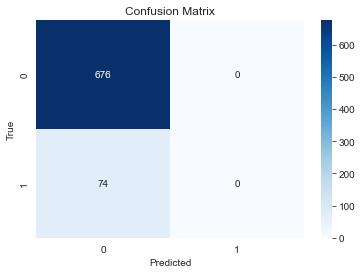

In [ ]:
# Evaluate the model on the test set
predictions = model.predict(test_encodings['input_ids'])
y_pred = tf.argmax(predictions.logits, axis=1)
y_true = test_df['target'].values
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(test_df.iloc[98].token_contract_code)




pragma solidity ^0.8.0;

library EnumerableSet {
    
    
    
    
    
    
    
    

    struct Set {
        
        bytes32[] _values;
        
        
        mapping(bytes32 => uint256) _indexes;
    }

    function _add(Set storage set, bytes32 value) private returns (bool) {
        if (!_contains(set, value)) {
            set._values.push(value);
            
            
            set._indexes[value] = set._values.length;
            return true;
        } else {
            return false;
        }
    }

    function _remove(Set storage set, bytes32 value) private returns (bool) {
        
        uint256 valueIndex = set._indexes[value];

        if (valueIndex != 0) {
            
            
            
            

            uint256 toDeleteIndex = valueIndex - 1;
            uint256 lastIndex = set._values.length - 1;

            if (lastIndex != toDeleteIndex) {
                bytes32 lastValue = set._values[lastIndex];

                
             

In [ ]:
test_df.iloc[98]

token_address                         0x9e59b2f4cec5ddf4d384ad6e05ed1ce6ec4732e1
pair_address                          0x679f8a7894c8016b30548b037665a571218fe649
weth_trade                                                             97.898925
weth_left                                                               3.204528
creation_time                                                         1677172343
launch_time                                                           1677171600
contract_type                                                                  0
token_contract_code            \n\n\npragma solidity ^0.8.0;\n\nlibrary Enume...
token_contract_comments        // SPDX-License-Identifier: MIT\n/**\nAI Eggs....
pair_contract                  // File: contracts/interfaces/IUniswapV2Pair.s...
time_difference                                                                0
target                                                                         1
token_contract_code_len     

In [ ]:
print(test_df.iloc[98].token_contract_comments)

// SPDX-License-Identifier: MIT
/**
AI Eggs. Tapping into the revolutionary debase mechanism in addition to bringing AI to the trading table 
An Eggs and Yolk fork with even MORE buyback and burns!

www.AIEggs.org
*/
/**
 * @dev Library for managing
 * https://en.wikipedia.org/wiki/Set_(abstract_data_type)[sets] of primitive
 * types.
 *
 * Sets have the following properties:
 *
 * - Elements are added, removed, and checked for existence in constant time
 * (O(1)).
 * - Elements are enumerated in O(n). No guarantees are made on the ordering.
 *
 * ```
 * contract Example {
 *     // Add the library methods
 *     using EnumerableSet for EnumerableSet.AddressSet;
 *
 *     // Declare a set state variable
 *     EnumerableSet.AddressSet private mySet;
 * }
 * ```
 *
 * As of v3.3.0, sets of type `bytes32` (`Bytes32Set`), `address` (`AddressSet`)
 * and `uint256` (`UintSet`) are supported.
 *
 * [WARNING]
 * ====
 * Trying to delete such a structure from storage will likely result in data